<h1>Pipeline de dados do Telegram na AWS</h1>

<h2>1. Contexto</h2>
<p>Esse projeto faz parte do material avaliativo do curso de profissão analista de dados da <a href="https://ebaconline.com.br/analista-de-dados">EBAC</a>. A sua estruturação se divide em 2 partes, sendo a primeira responsável pelo sistema transacional, ou seja, o grupo responsável pelos elementos do Telegram (chatbot e suas configurações). Já a segunda parte é encarregada pelo sistema analítico, na qual, envolve a ingestão dos dados, o método ETL, a apresentação dos dados (via AWS Athena), e por fim, o método extra de atualização dos dados de apresentação.</p>

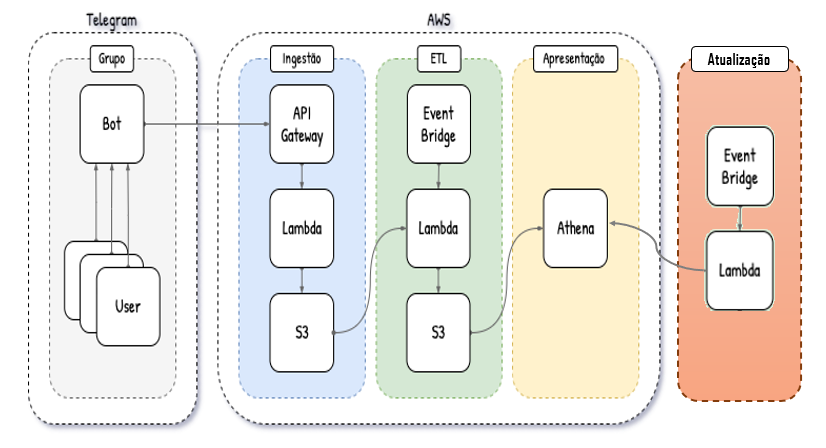

<h2>Bibliotecas:</h2>

In [1]:
import json
import requests

from getpass import getpass

## 1\. Ingestão

Replique as atividades da aula 1.

1.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados crus, não se esqueça de adicionar o sufixo `-raw`.

1.2. Crie uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. Não se esqueça de configurar as variáveis de ambiente e de adicionar as permissão de interação com `AWS S3` no `AWS IAM`.

> **Nota**: Para testar a função com evento do próprio `AWS Lambda`, substitua o código `message = json.loads(event["body"])` por `message = event`. Lembre-se que o primeiro só faz sentido na integração com o `AWS API Gateway`.

1.3. Crie uma API no `AWS API Gateway` a conecte a função do `AWS Lambda`, conforme apresentado na aula.

> **Nota**: não disponibilize o endereço da API gerada.

In [2]:
aws_api_gateway_url = getpass()

 ··························································


1.4. Configura o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. utilize o endereço da API criada no `AWS API Gateway`. Utilize o método `getWebhookInfo` para consultar a integração.

> **Nota**: não disponibilize o *token* de acesso ao seu *bot* da API de *bots* do **Telegram**.

In [3]:
# Token de acesso:
token = getpass()
# Link da API do telegram:
base_url = f'https://api.telegram.org/bot{token}'

 ··············································


In [4]:
# setWebhook:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')
print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook is already set"
}


In [5]:
# confirmando se o getWebhookInfo:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://lvo0xy7wai.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "18.228.75.249"
  }
}


## 2\. ETL

Replique as atividades da aula 2.

2.1. Crie um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos, não se esqueça de adicionar o sufixo `-enriched`.

2.2. Cria uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. Salve o resultado em um único arquivo PARQUET, também particionado por dia. Não se esqueça de configurar as variáveis de ambiente, de adicionar as permissão de interação com `AWS S3` no `AWS IAM`, de configurar o *timeout* e de adicionar a *layer* com o código do pacote Python PyArrow.

> **Nota**: Para testar a função, substitua o código `date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por `date = (datetime.now(tzinfo) - timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia.

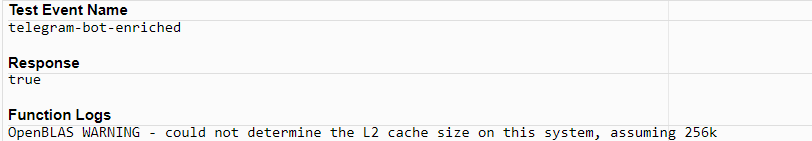

2.3. Crie uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

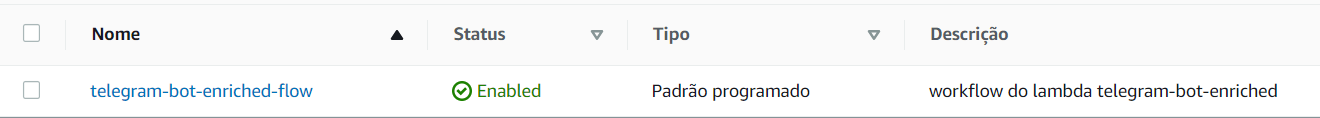

## 3\. Apresentação

Replique as atividades da aula 3.

3.1. Cria a tabela no `AWS Athena` que aponte para os dados armazenados no bucket enriquecido do `AWS S3`.

SQL:<pre><code>CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint, 
  `user_id` bigint, 
  `user_is_bot` boolean, 
  `user_first_name` string, 
  `chat_id` bigint, 
  `chat_type` string, 
  `text` string, 
  `date` bigint)
PARTITIONED BY ( 
  `context_date` date)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://datalake-telegram-bot-enriched/telegram/'
</code></pre>

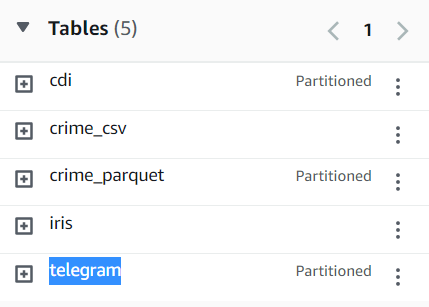

3.2. Execute o comando `MSCK REPAIR TABLE <nome-tabela>` para carregar as partições.

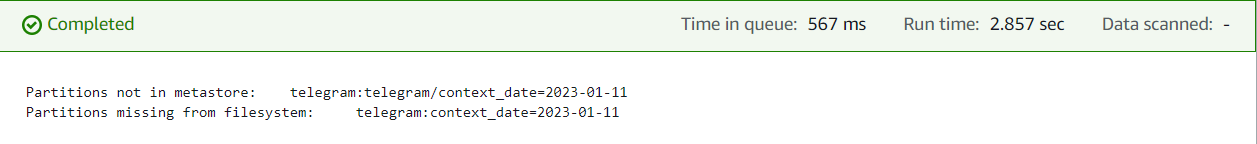

3.2.1 Para automatizar o <code>MSCK REPAIR TABLE `nome-tabela`</code> foi criado o lambda:

<pre><code>import os

import boto3

def lambda_handler(event, context):
    bucket_name = 's3://datalake-telegram-bot-enriched/telegram/'

    client = boto3.client('athena')

    config = {
        'OutputLocation': bucket_name
    }

    # Query Execution Parameters
    sql = 'MSCK REPAIR TABLE default.telegram'
    context = {'Database': 'default'}
    try:
        client.start_query_execution(QueryString = sql, 
                                 QueryExecutionContext = context,
                                 ResultConfiguration = config)
    except:
        print("An exception occurred")
</pre></code>

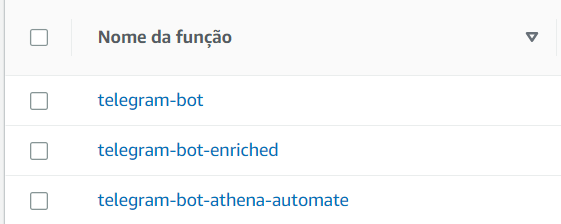

<li>Definindo workflow para o lambda rodar todos os dias 1h após a execução do <em>telegram-bot-enriched</em>:

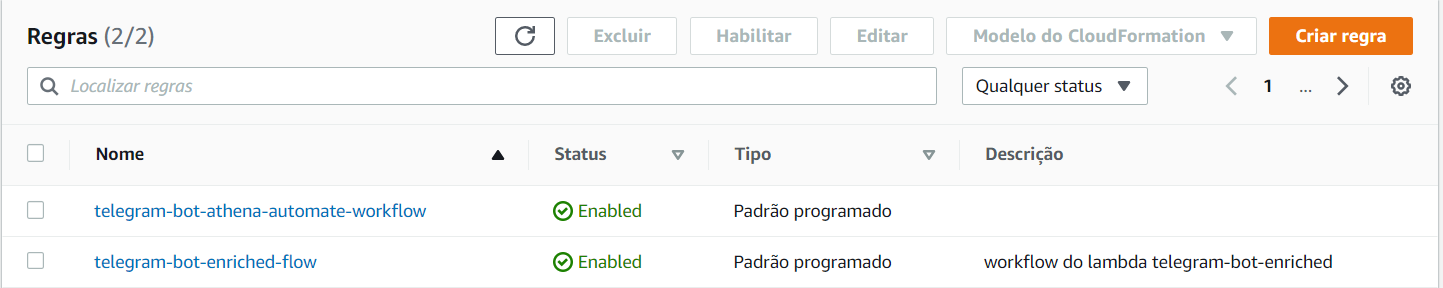

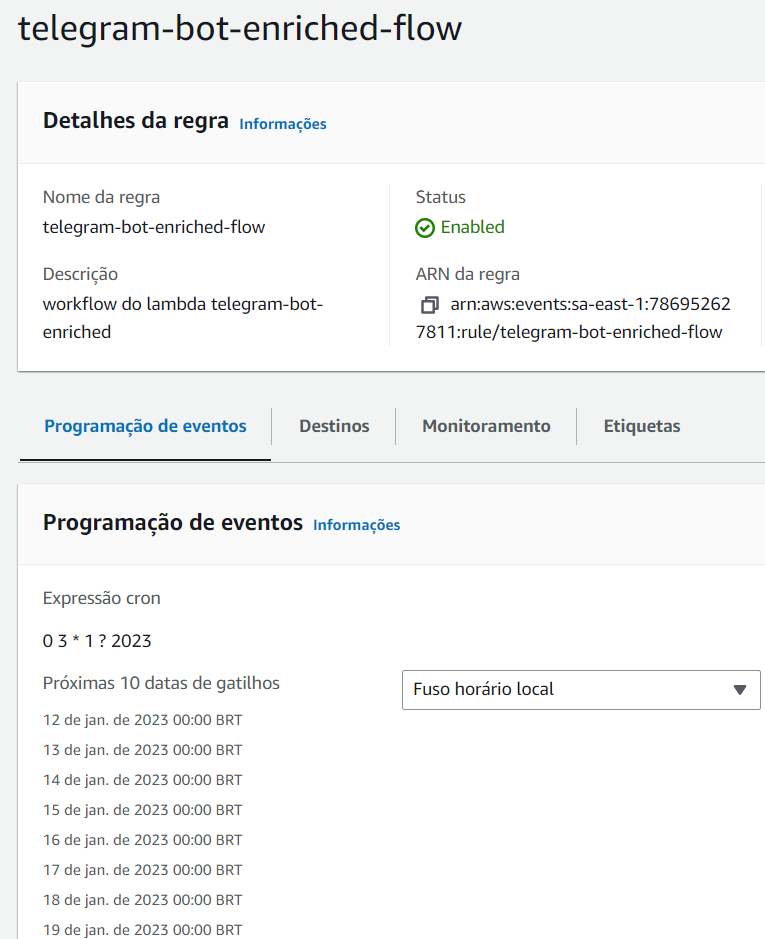

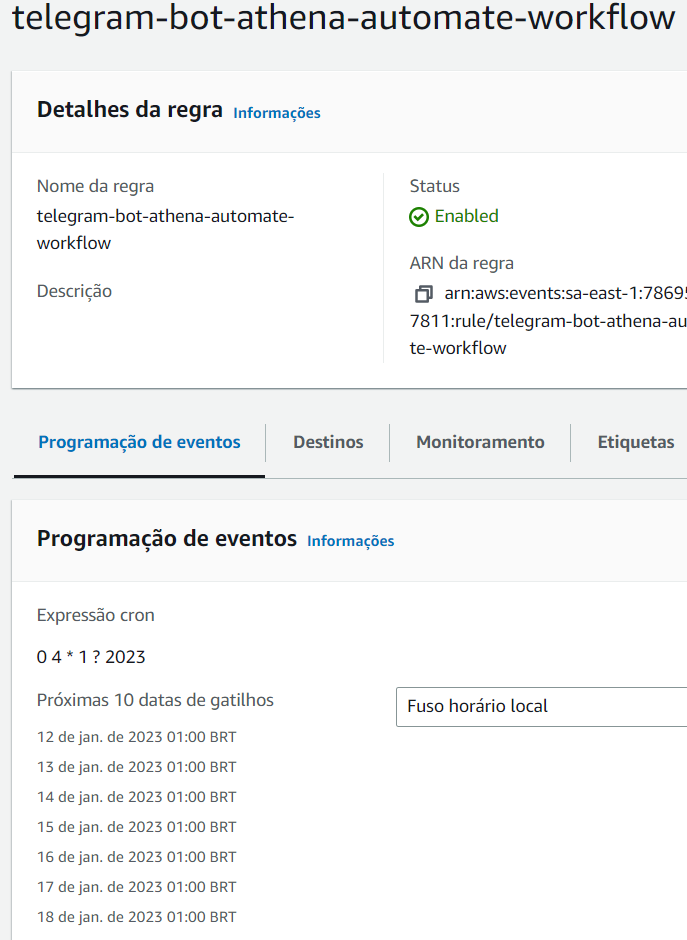

3.3. Execute as consultas SQL para explorar os dados.

Para verificar as informações da tabela:
<br>
query: <code>SELECT * FROM "default"."telegram" limit 10;</code>

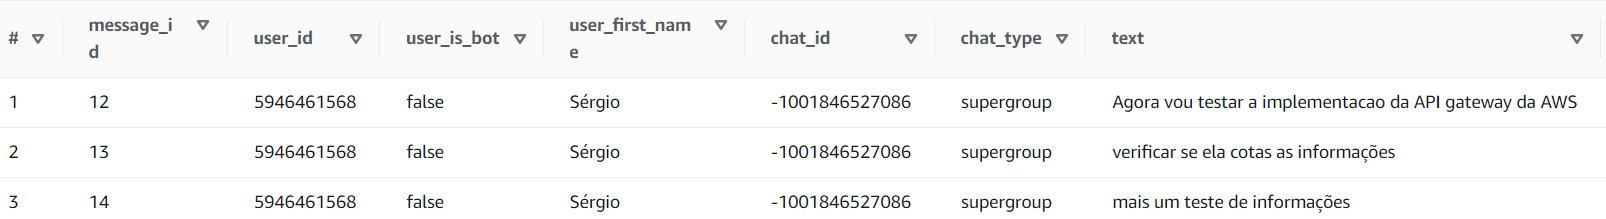

<li>consultar quantidade de mensagens no dia:
<br>
Query:


<pre><code>SELECT 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY context_date 
ORDER BY context_date DESC
</code></pre>

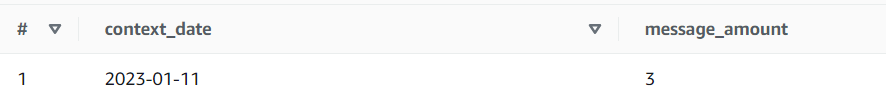

<li> Média do tamanho das mensagens por usuário por dia.
<pre><code>SELECT 
  user_id, 
  user_first_name, 
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
</pre></code>

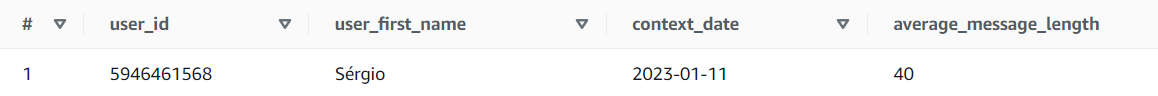